#### 9517 Group Project
#### Unet_Improved_Miou
#### Yining Liu z5466010


Because pre-trained model is so large over 100MB. I upload it to google drive.
Please! 
Download [pre-trained model](https://drive.google.com/file/d/1ViYOYjBqGGWS6Ojrj2QwRpgUehWpf_S2/view?usp=sharing) first.
And put it in folder named TurtleUnet. 
If the download fails, please contact me（z5466010 or yining.liu3@student.unsw.edu.au or yining.liu0126@gmail.com ）.
Thank you for your patience.

For more information, please read the readme.

In [2]:
import os
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define category color mapping
category_colors = {
    1: (0, 0, 255),    # Shell - Blue
    2: (0, 255, 0),    # Flipper - Green
    3: (255, 0, 0)     # Head - Red
}

# Function to create mask from segmentation
def create_mask_from_segmentation(segmentation, category_id):
    rle = {'counts': segmentation['counts'], 'size': segmentation['size']}
    if isinstance(rle['counts'], list):
        rle = maskUtils.frPyObjects(rle, rle['size'][0], rle['size'][1])
    binary_mask = maskUtils.decode(rle)
    binary_mask = (binary_mask * category_id).astype(np.uint8)
    return binary_mask

# Define dataset class
class TurtleDataset(Dataset):
    def __init__(self, dataset_dir, csv_data, annotations_path, img_shape=(512, 512)):
        self.dataset_dir = dataset_dir
        self.csv_data = csv_data
        self.coco = COCO(annotations_path)
        self.img_shape = img_shape
        self.image_ids = self.csv_data['id'].tolist()
        self.file_names = self.csv_data['file_name'].tolist()
        self.transform = transforms.Compose([
            transforms.Resize(img_shape),
            transforms.ToTensor(),
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(img_shape, interpolation=Image.NEAREST),
        ])
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.dataset_dir, self.file_names[idx])
        image = Image.open(image_path).convert('RGB')
        original_size = image.size  # (width, height)
        
        # Create mask
        mask = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
        for ann in annotations:
            category_id = ann['category_id']
            if category_id < 4:
                binary_mask = create_mask_from_segmentation(ann['segmentation'], category_id)
                mask = np.maximum(mask, binary_mask)
        mask[mask >= 4] = 0
        mask = Image.fromarray(mask)
        
        # Apply transforms
        image = self.transform(image)
        mask = self.mask_transform(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.uint8)).long().squeeze()
        
        return image, mask

# Data paths and parameters
image_root_folder = 'archive/turtles-data/data'
file_path = 'archive/turtles-data/data/metadata_splits.csv'
annotations_path = os.path.join(image_root_folder, 'annotations.json')
data = pd.read_csv(file_path)

# Randomly sample 30% of the total data
subset_data = data.sample(frac=0.3, random_state=42)

# Split the data according to the SeaTurtleID2022 dataset definition
train_data = subset_data[subset_data['split_open'] == 'train']  # Use 'train' in split_open as training set
val_data = subset_data[subset_data['split_open'] == 'test']     # Use 'test' in split_open as validation set
test_data = subset_data[subset_data['split_closed'] == 'test']  # Use 'test' in split_closed as test set

# Create datasets and data loaders
train_dataset = TurtleDataset(image_root_folder, train_data, annotations_path)
val_dataset = TurtleDataset(image_root_folder, val_data, annotations_path)
test_dataset = TurtleDataset(image_root_folder, test_data, annotations_path)


batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


c:\Users\Raytrack\anaconda3\envs\torch1101\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading annotations into memory...
Done (t=4.34s)
creating index...
index created!
loading annotations into memory...


c:\Users\Raytrack\anaconda3\envs\torch1101\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
c:\Users\Raytrack\anaconda3\envs\torch1101\lib\site-packages\torchvision\transforms\transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Done (t=4.46s)
creating index...
index created!
loading annotations into memory...
Done (t=4.10s)
creating index...
index created!


In [3]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Define model, using pretrained weights
num_classes = 4  # Including background
model = smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', in_channels=3, classes=num_classes)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
class_weights = torch.tensor([0.1, 1.0, 2.0, 3.0]).to(device)
from segmentation_models_pytorch.losses import DiceLoss
dice_loss = DiceLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss(weight=class_weights)

def criterion(outputs, masks):
    return ce_loss(outputs, masks) + dice_loss(outputs, masks)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [4]:
from tqdm import tqdm

# Train the model
epochs = 1
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation")
    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_loader_tqdm.set_postfix(loss=loss.item())
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss}")

Epoch 1/1 - Training: 100%|██████████| 409/409 [08:28<00:00,  1.24s/it, loss=0.605]


Epoch 1/1, Loss: 1.1464074587763669


Epoch 1/1 - Validation: 100%|██████████| 172/172 [04:02<00:00,  1.41s/it, loss=1.98]

Validation Loss: 2.619336171898731


In [16]:
from tqdm import tqdm

# Train the model
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation")
    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_loader_tqdm.set_postfix(loss=loss.item())
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss}")

Epoch 1/3 - Training: 100%|██████████| 459/459 [08:21<00:00,  1.09s/it, loss=0.844]


Epoch 1/3, Loss: 1.0536320498436365


Epoch 1/3 - Validation: 100%|██████████| 99/99 [02:11<00:00,  1.33s/it, loss=1.29] 


Validation Loss: 1.1435842646492853


Epoch 2/3 - Training: 100%|██████████| 459/459 [10:25<00:00,  1.36s/it, loss=1.34] 


Epoch 2/3, Loss: 0.7549073885079303


Epoch 2/3 - Validation: 100%|██████████| 99/99 [02:11<00:00,  1.33s/it, loss=0.75] 


Validation Loss: 1.0876514532349326


Epoch 3/3 - Training: 100%|██████████| 459/459 [10:25<00:00,  1.36s/it, loss=0.913]


Epoch 3/3, Loss: 0.6198452139082558


Epoch 3/3 - Validation: 100%|██████████| 99/99 [02:09<00:00,  1.31s/it, loss=0.474]

Validation Loss: 0.5398983923774777


In [5]:
# Define evaluation function
import torch
import numpy as np

model_path = 'final_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Define IoU calculation function
def compute_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(1, num_classes):  # Skip background class 0
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  # Avoid division by zero
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious  # Return list of IoUs for each class
    
def evaluate_model(test_loader, model, device, num_classes):
    test_loss = 0.0
    all_preds = []
    all_masks = []
    
    # Evaluate on the test set
    model.eval()
    test_loader_tqdm = tqdm(test_loader, desc="Testing")
    with torch.no_grad():
        for images, masks in test_loader_tqdm:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
            test_loader_tqdm.set_postfix(loss=loss.item())
    
    # Calculate average test loss
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss}")

    # Calculate overall accuracy
    total_correct = 0
    total_pixels = 0
    for preds, masks in zip(all_preds, all_masks):
        total_correct += (preds == masks).sum().item()
        total_pixels += torch.numel(preds)
    test_accuracy = total_correct / total_pixels
    print(f"Test Accuracy (including background): {test_accuracy}")

    # Calculate mIoU for each class
    all_preds = torch.cat(all_preds)
    all_masks = torch.cat(all_masks)
    ious = compute_iou(all_preds, all_masks, num_classes)
    mean_iou = np.nanmean(ious)
    print(f"Test Mean IoU (mIoU): {mean_iou}")

    # Print mIoU for each class
    class_names = ["shell", "flipper", "head"]
    for cls, class_name in enumerate(class_names, 1):  # Category IDs are 1, 2, 3
        iou = ious[cls-1]
        print(f"{class_name} mIoU: {iou:.4f}")

# Call evaluation function
evaluate_model(test_loader, model, device, num_classes)


Testing: 100%|██████████| 193/193 [04:18<00:00,  1.34s/it, loss=0.0371]


Test Loss: 0.10819465815634925
Test Accuracy (including background): 0.9956473908381085
Test Mean IoU (mIoU): 0.9503002983673697
shell mIoU: 0.9643
flipper mIoU: 0.9397
head mIoU: 0.9470


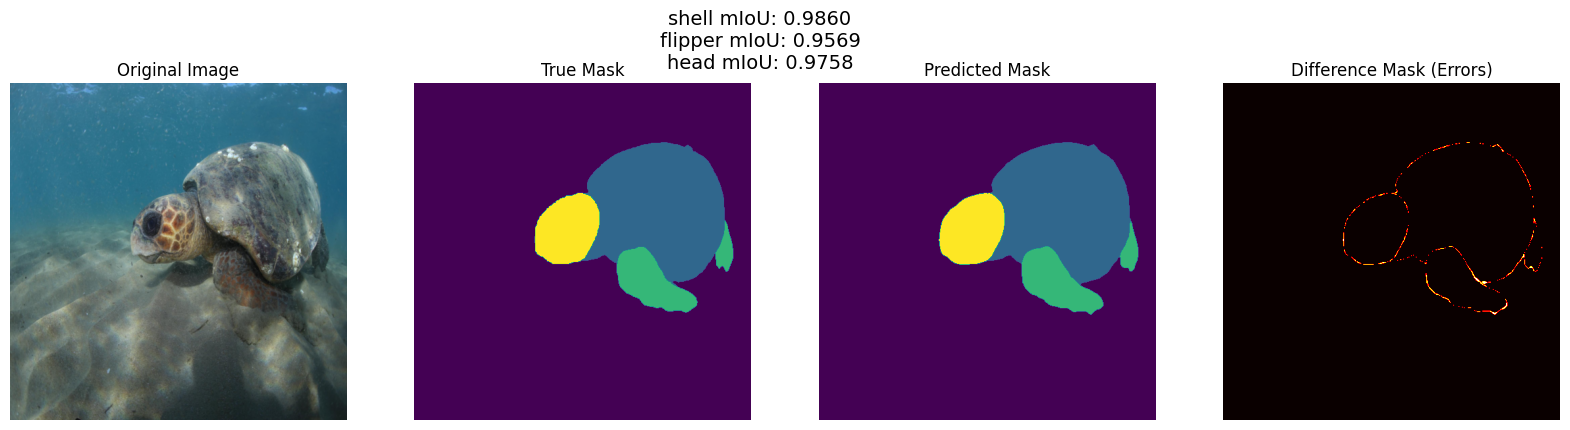

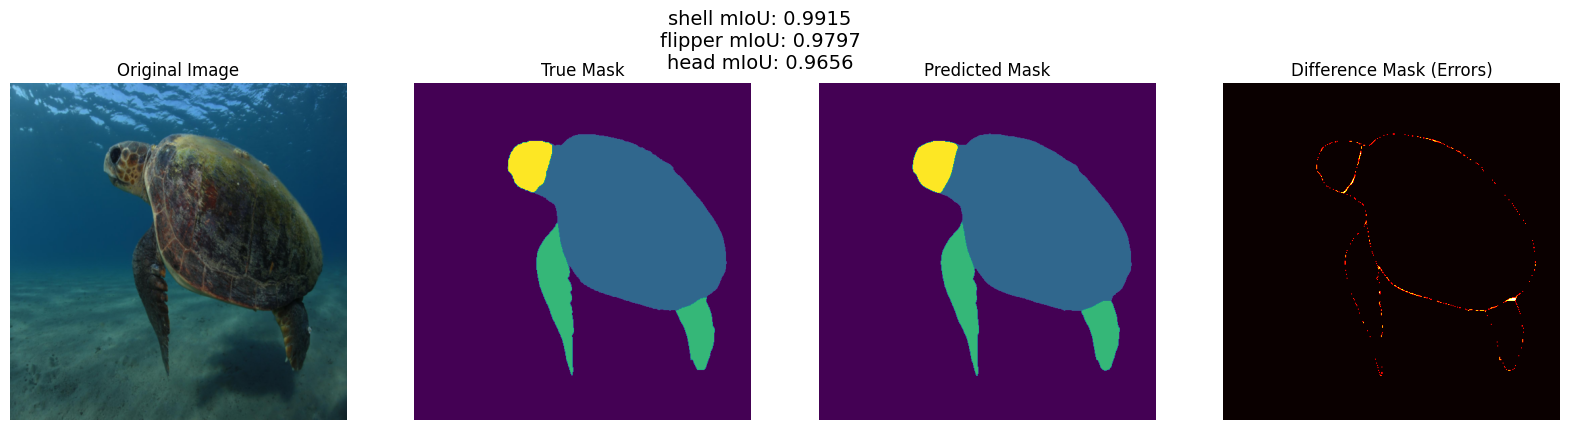

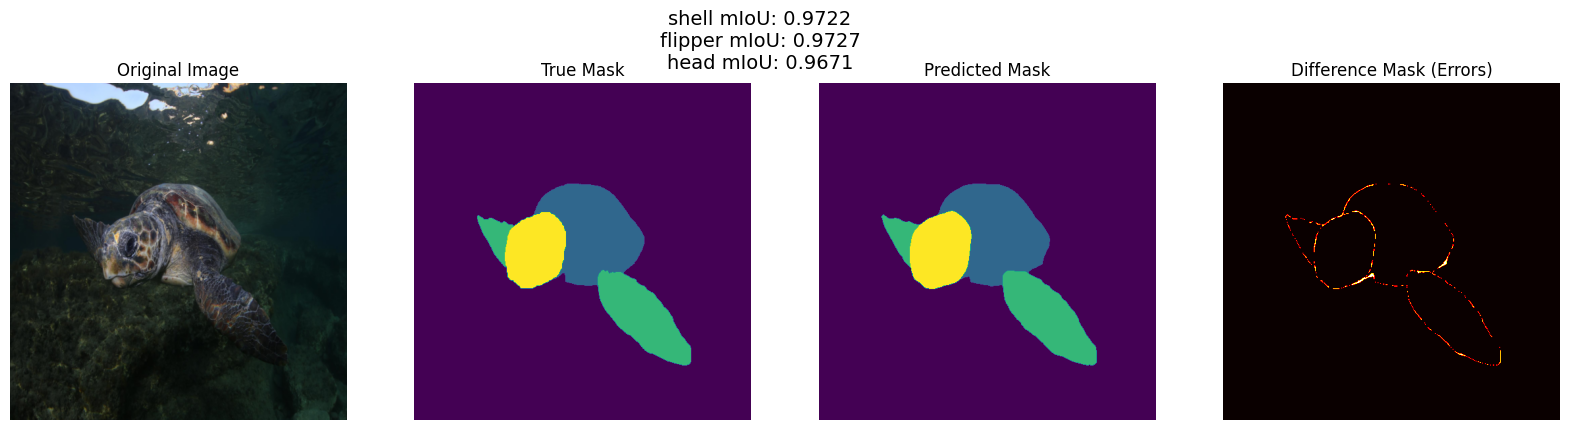

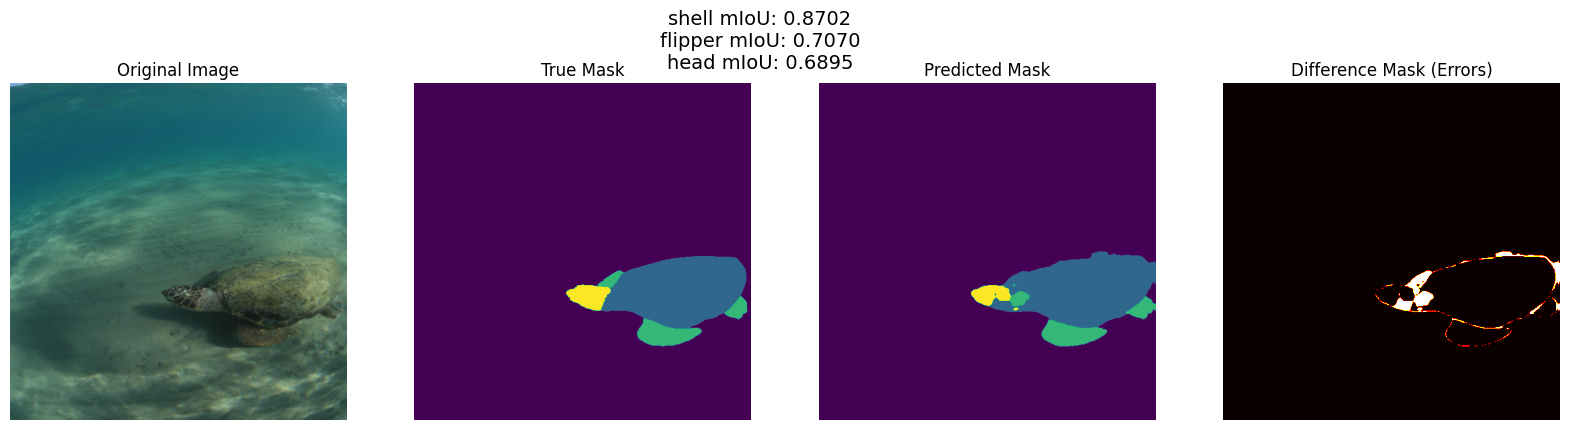

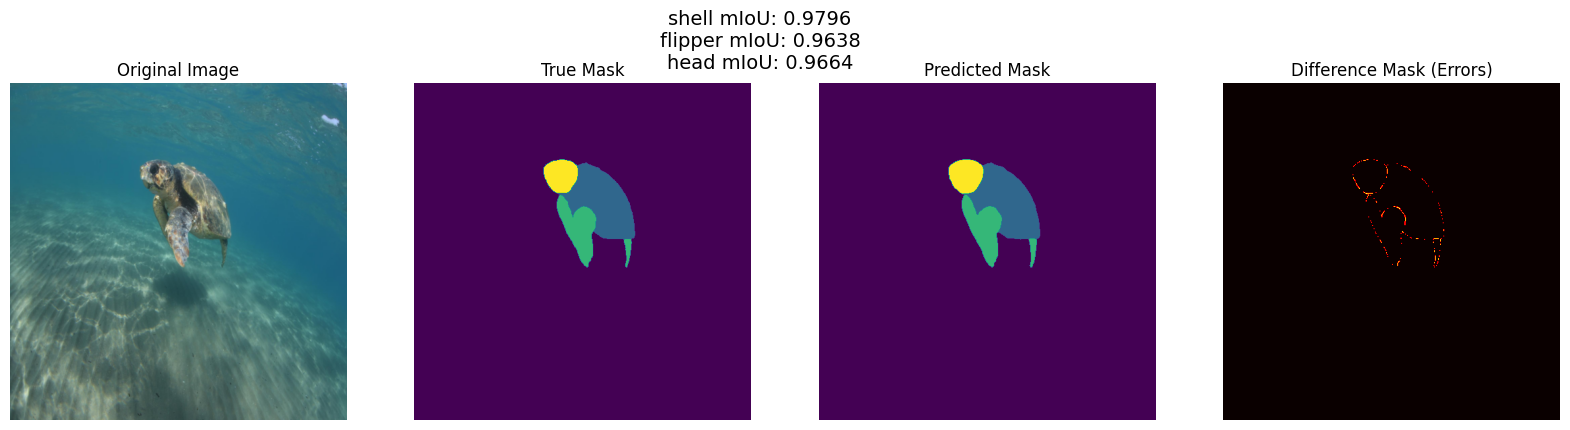

In [6]:
import matplotlib.pyplot as plt
import random

# Define visualization function
def visualize_predictions(dataset, model, class_names, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        image, mask = dataset[idx]
        image_input = image.to(device).unsqueeze(0)
        
        with torch.no_grad():
            output = model(image_input)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        # Process original image
        image_np = image.cpu().numpy().transpose(1, 2, 0)
        image_np = np.clip(image_np, 0, 1)
        true_mask = mask.numpy()
        
        # Convert masks to uint8
        pred_mask = pred_mask.astype(np.uint8)
        true_mask = true_mask.astype(np.uint8)
        diff_mask = (true_mask != pred_mask).astype(np.uint8)
        
        # Visualization
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image_np)
        axs[0].set_title("Original Image")
        axs[0].axis('off')
        
        axs[1].imshow(true_mask, cmap='viridis')
        axs[1].set_title("True Mask")
        axs[1].axis('off')
        
        axs[2].imshow(pred_mask, cmap='viridis')
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')
        
        axs[3].imshow(diff_mask, cmap='hot')
        axs[3].set_title("Difference Mask (Errors)")
        axs[3].axis('off')
        
        # Calculate IoU for each class and add as title
        ious_sample = compute_iou(torch.tensor(pred_mask), torch.tensor(true_mask), num_classes)
        iou_text = "\n".join([f"{name} mIoU: {iou:.4f}" for name, iou in zip(class_names, ious_sample)])
        fig.suptitle(iou_text, fontsize=14)
        
        plt.show()
# Define class names (assuming these are the class labels)
class_names = ["shell", "flipper", "head"]


# Visualize samples from the test set
visualize_predictions(test_dataset, model, class_names, num_samples=5)
